In [1]:
from notebook_init import *

out_root = Path('out/semantic')
makedirs(out_root, exist_ok=True)

# StyleGAN2 FFHQ

In [2]:
use_w = True
dataset = 'ffhq'
inst = get_instrumented_model('StyleGAN2', dataset, 'style', device, inst=inst, use_w=use_w)
model = inst.model
model.truncation = 1.0

gs_dir = np.load('./global_directions/ganspace_directions_ffhq_stylegan2.npy')#Note! Only ffhq is provided.
gs_dir = torch.from_numpy(gs_dir).to(device)

Loading ../models/checkpoints/stylegan2/stylegan2_ffhq_1024.pt


## GANSpace guided semantic

In [3]:
configs = [
#     (6, 8, 'ffhq', -20.0, 43, 'Disgusted', [140658858, 1887645531]),
#     (8, 9, 'ffhq', 9.0, 0, 'Makeup', [266415229, 375122892]),
#     (4, 5, 'ffhq', 10.0, 19, 'Big smile', [427229260]),
#     (6, 8, 'ffhq', -20.0, 33, 'Scary eyes', [1887645531]),
#     (2, 5, 'ffhq', 18.2, 21, 'Bald', [1635892780]),
#     (8, 9, 'ffhq', 13.0, 13, 'Bright BG vs FG', [798602383]),
#     (3, 6, 'ffhq', -60.0, 47, 'Curly hair', [1140578688]),
#     (8, 9, 'ffhq', -10.2, 16, 'Hair albedo', [427229260]),
#     (4, 7, 'ffhq', 10.0, 36, 'Displeased', [1887645531]),
#     (8, 9, 'ffhq', 20.0, 37, 'Eyebrow thickness', [1887645531]),
#     (7, 8, 'ffhq', -30.0, 54, 'Eye openness', [11573701]),
#     (0, 5, 'ffhq', 20.0, 37, 'Face roundness', [1887645531]),
#     (4, 10, 'ffhq', -20.0, 54, 'Fearful eyes', [11573701]),
#     (4, 5, 'ffhq', -13.6, 21, 'Hairline', [1635892780]),
#     (0, 8, 'ffhq', 20.0, 30, 'Happy frizzy hair', [1887645531]),
    (1, 4, 'ffhq', -10, 11, 'Eyeglasses', [140658858]), # paper
    (3, 6, 'ffhq', -5, 23, 'In awe', [1635892780]), # paper
#     (3, 6, 'ffhq', -5, 22, 'Large jaw', [1635892780]),
#     (10, 11, 'ffhq', 20.0, 34, 'Lipstick', [1887645531]),
#     (4, 5, 'ffhq', -30.0, 51, 'Nose length', [11573701]),
#     (8, 18, 'ffhq', 5.0, 27, 'Overexposed', [1887645531]),
#     (3, 7, 'ffhq', -14.5, 35, 'Screaming', [1887645531]),
    (2, 6, 'ffhq', -10, 32, 'Short face', [1887645531]), # paper
#     (4, 5, 'ffhq', -20.0, 46, 'Smile', [1175071341]),
#     (4, 5, 'ffhq', -20.0, 20, 'Unhappy bowl cut', [1635892780]),
    (8, 9, 'ffhq', -8, 10, 'Sunlight in face', [798602383]), # paper
#     (7, 9, 'ffhq', -40.0, 58, 'Trimmed beard', [1602858467]),
#     (3, 5, 'ffhq', -9.0, 20, 'Forehead hair', [1382206226]),
#     (0, 5, 'ffhq', -9.0, 21, 'Happy frizzy hair', [1382206226]),
#     (8, 9, 'ffhq', -15.0, 25, 'Light UD', [1382206226]),
#     (8, 11, 'ffhq', 9.0, 0, 'Makeup', [1953272274]),
#     (4, 6, 'ffhq', -16.0, 36, 'Smile', [1382206226]),
]

140658858
Getting iter trvs took 2.6782591342926025
GANSpace
Local Basis
Iterative Curve Traversal


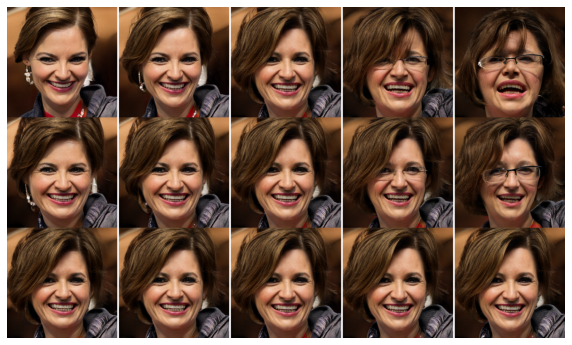

semantic=Eyeglasses, intensity=-10, cos_sim=0.3056255280971527

1635892780
Getting iter trvs took 2.6701457500457764
GANSpace
Local Basis
Iterative Curve Traversal


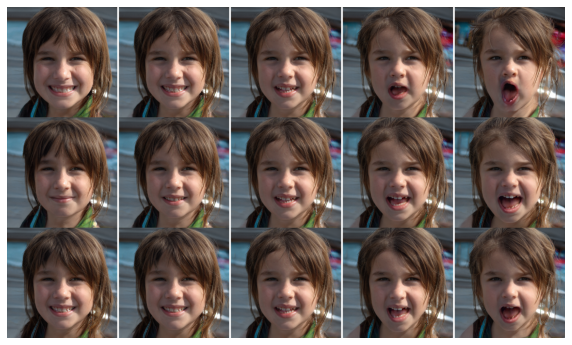

semantic=In awe, intensity=-5, cos_sim=0.2326730191707611

1887645531
Getting iter trvs took 2.7858922481536865
GANSpace
Local Basis
Iterative Curve Traversal


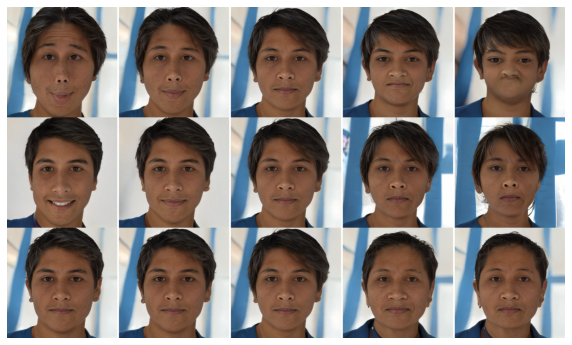

semantic=Short face, intensity=-10, cos_sim=0.21229727566242218

798602383
Getting iter trvs took 2.637789011001587
GANSpace
Local Basis
Iterative Curve Traversal


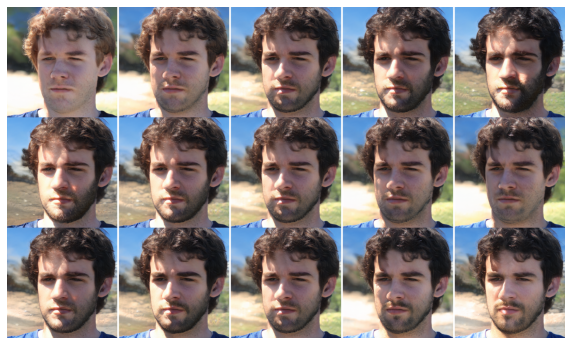

semantic=Sunlight in face, intensity=-8, cos_sim=0.27701234817504883



In [4]:
torch.autograd.set_grad_enabled(True)
img_save = 0
num_frames = 5
for config in configs:
    layer_start, layer_end, dataset, perturb_intensity, d, semantic, seeds = config
    for seed in seeds:
        print(seed)
        rng = np.random.RandomState(seed)
        noise, z, z_local_basis, z_sv, noise_basis = get_random_local_basis(model, rng)
        ''' rename & reshape'''    
        local_lat_comp = z_local_basis.t().unsqueeze(1).detach().to(device)
        local_lat_mean = z.detach().to(device)
        strips = []
        
        sim = compare_basis_componentwise(gs_dir[d], z_local_basis.t().cuda())[0]
        d_cp = torch.argmax(abs(sim))
        ori = torch.sign(sim[0][d_cp])
#         if semantic in ['Sunlight in face','Head angle up']:
#             perturb_intensity = perturb_intensity * 2
        batch_frames_gs = create_strip_centered(inst, 'latent', 'style', [z],
            0, gs_dir[d], 0, 1, 0, z, perturb_intensity, layer_start, layer_end, num_frames=num_frames)[0]
        batch_frames_cp = create_strip_centered(inst, 'latent', 'style', [z],
                            0, ori * local_lat_comp[d_cp], 0, 1, 0, z, perturb_intensity, layer_start, layer_end, num_frames=num_frames)[0]
        batch_frames_it = create_strip_iter(inst, 'latent', 'style', d_cp, sigma = perturb_intensity, layer_start = layer_start, layer_end = layer_end, 
                                             random_state = None, noise = noise, compare_basis = True, num_frames=num_frames, num_steps = 50, verbose=0)[0][0]
        strips.append(np.hstack(pad_frames(batch_frames_gs)))
        strips.append(np.hstack(pad_frames(batch_frames_cp)))
        strips.append(np.hstack(pad_frames(batch_frames_it)))

        grid = np.vstack(strips)
        if img_save:
            Image.fromarray(np.uint8(grid*255)).save(out_root / /f'{dataset}_semantic_{seed}_layer{layer_start}to{layer_end}_{semantic}.jpg')
        else:
            print("GANSpace")
            print("Local Basis")
            print("Iterative Curve Traversal")
            plt.figure(figsize=(10,20))
            plt.imshow(grid)
            plt.axis('off')
            plt.show()
            print(f"semantic={semantic}, intensity={perturb_intensity}, cos_sim={sim[0][d_cp]}")
            print()
            

# StyleGAN2 LSUN Cat

In [20]:
use_w = True
dataset = 'cat'
inst = get_instrumented_model('StyleGAN2', dataset, 'style', device, inst=inst, use_w=use_w)
model = inst.model
model.truncation = 1.0

Loading ../models/checkpoints/stylegan2/stylegan2_cat_256.pt


In [21]:
configs = [{'seed': 889979887, 'basis': [1], 'layer_mode': 'all', 'semantic':'age', 'perturb_intensity':4, 'num_frames': 5},
{'seed': 889979887, 'basis': [4], 'layer_mode': 'coarse', 'semantic':'stand_up', 'perturb_intensity':10, 'num_frames': 5},
{'seed': 889979887, 'basis': [0], 'layer_mode': 'fine', 'semantic':'color', 'perturb_intensity':12, 'num_frames': 5},
{'seed': 889979887, 'basis': [18], 'layer_mode': 'fine', 'semantic':'pattern', 'perturb_intensity':12, 'num_frames': 5}]

889979887


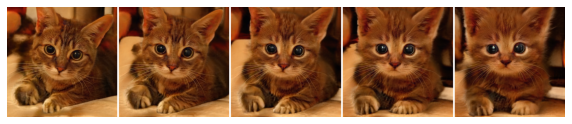

age
889979887


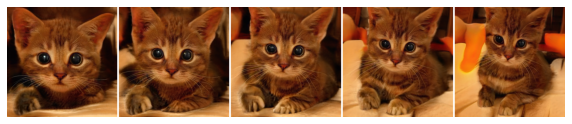

stand_up
889979887


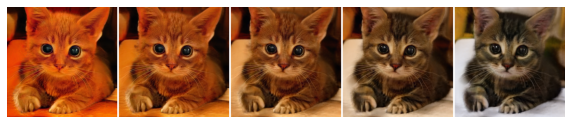

color
889979887


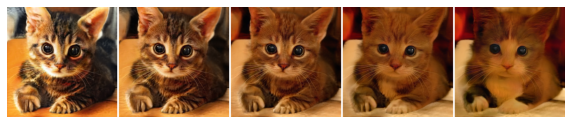

pattern


In [22]:
print_shape = True
torch.autograd.set_grad_enabled(True)
save_img = 0
for cat_dict in configs:
    # Case 1: Normal centered PCs
    seed, basis, layer_mode, semantic, perturb_intensity, num_frames = cat_dict.values()
    print(seed)
    rng = np.random.RandomState(seed)
    noise, z, z_local_basis, z_sv, noise_basis = get_random_local_basis(model, rng)
    local_lat_comp = z_local_basis.t().unsqueeze(1).detach().to(device)
    local_lat_mean = z.detach().to(device)
    layer_start, layer_end = LayerMode(layer_mode)
    strips = []

    with torch.no_grad():
        for i in basis:
            batch_frames = create_strip_centered(inst, 'latent', 'style', [z],
                        0, local_lat_comp[i], 0, 1, 0, z, perturb_intensity, layer_start, layer_end, num_frames=num_frames)[0]
            strips.append(np.hstack(pad_frames(batch_frames)))
    #             for j, frame in enumerate(batch_frames):
    #                 Image.fromarray(np.uint8(frame*255)).save(out_root / 'global' / f'{seed}_pc{i}_{j}.png')

    #col_left = np.vstack(pad_frames(strips[:n_pcs//2], 0, 64))
    #col_right = np.vstack(pad_frames(strips[n_pcs//2:], 0, 64))
    grid = np.vstack(strips)

    if save_img:
        Image.fromarray(np.uint8(grid*255)).save(out_root / f'{dataset}_semantic_{seed}_layer{layer_start}to{layer_end}_{semantic}.jpg')
    else:
        plt.figure(figsize=(10,20))
        plt.imshow(grid)
        plt.axis('off')
        plt.show()
        print(semantic)

# StyleGAN2 LSUN Car

In [23]:
use_w = True
dataset = 'car'
inst = get_instrumented_model('StyleGAN2', dataset, 'style', device, inst=inst, use_w=use_w)
model = inst.model
model.truncation = 1.0

Loading ../models/checkpoints/stylegan2/stylegan2_car_512.pt


In [24]:

configs =[
    #1881703227
    {'seed': 1881703227, 'basis': [0], 'layer_mode': 'coarse', 'semantic':'zoom', 'perturb_intensity':5, 'num_frames': 9},
    {'seed': 1881703227, 'basis': [26], 'layer_mode': 'fine', 'semantic':'background', 'perturb_intensity':10, 'num_frames': 9},
    {'seed': 1881703227, 'basis': [2], 'layer_mode': 'coarse', 'semantic':'rotate', 'perturb_intensity':10, 'num_frames': 9},
    {'seed': 1881703227, 'basis': [11], 'layer_mode': 'middle', 'semantic':'car_style', 'perturb_intensity':12, 'num_frames': 9},
    
    #1150529896
    {'seed': 1150529896, 'basis': [3], 'layer_mode': 'middle', 'semantic':'car_style', 'perturb_intensity':10, 'num_frames': 9}, 
    {'seed': 1150529896, 'basis': [9], 'layer_mode': 'fine', 'semantic':'color', 'perturb_intensity':12, 'num_frames': 9},
    {'seed': 1150529896, 'basis': [1], 'layer_mode': 'all', 'semantic':'rotate', 'perturb_intensity':10, 'num_frames': 9},
    
    #1839348078
    {'seed': 1839348078, 'basis': [4], 'layer_mode': 'coarse', 'semantic':'rotate', 'perturb_intensity':15, 'num_frames': 9} #paper
    {'seed': 1839348078, 'basis': [1], 'layer_mode': 'coarse', 'semantic':'body_length', 'perturb_intensity':10, 'num_frames': 9}, #paper
    {'seed': 1839348078, 'basis': [1, 6], 'layer_mode': 'middle', 'semantic':'vehicle_type', 'perturb_intensity':10, 'num_frames': 9}, #paper
    {'seed': 1839348078, 'basis': [0,22], 'layer_mode': 'fine', 'semantic':'color', 'perturb_intensity':10, 'num_frames': 9}, #paper
]

1881703227


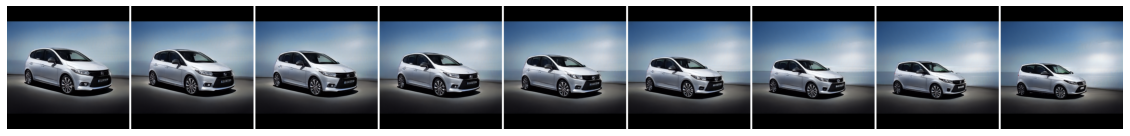

zoom
1881703227


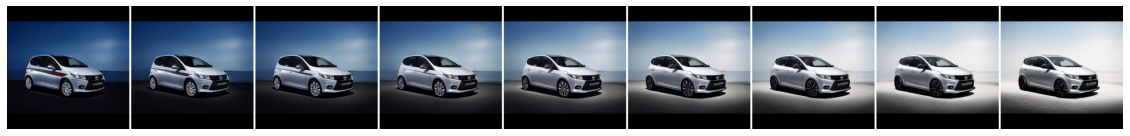

background
1881703227


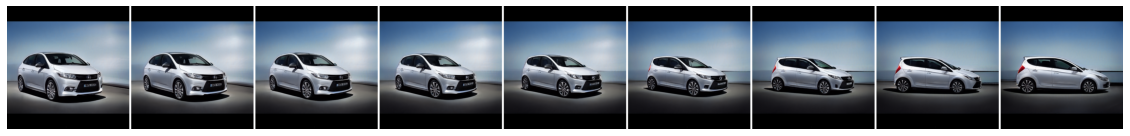

rotate
1881703227


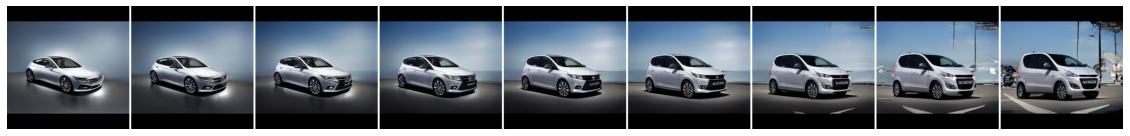

car_style
1150529896


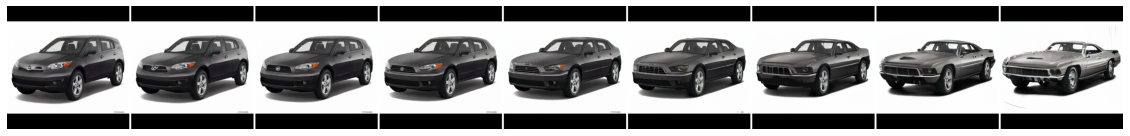

car_style
1150529896


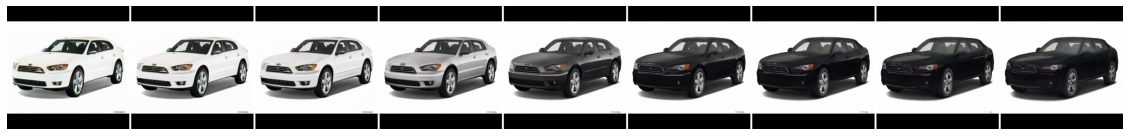

color
1150529896


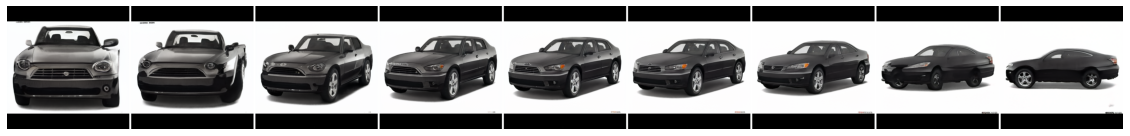

rotate
1839348078


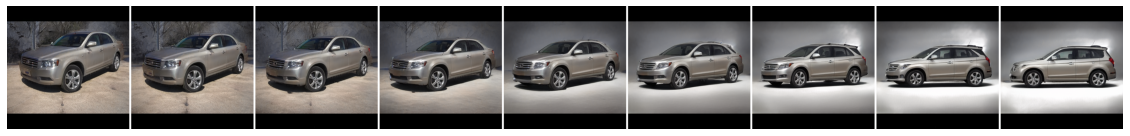

rotate
1839348078


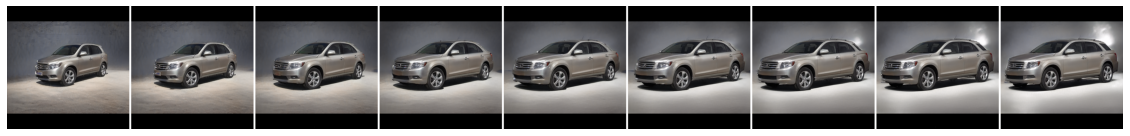

body_length
1839348078


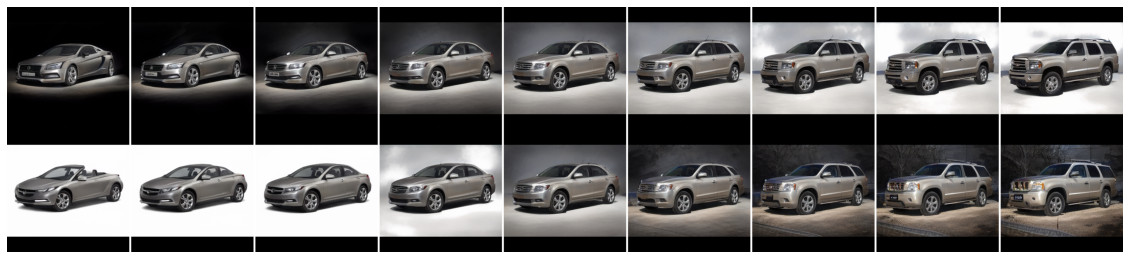

vehicle_type
1839348078


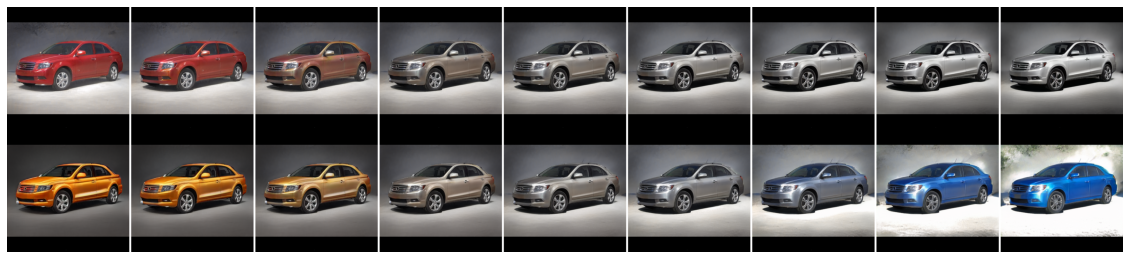

color


In [25]:
print_shape = True
torch.autograd.set_grad_enabled(True)
save_img = 0
for car_dict in configs:
    # Case 1: Normal centered PCs
    seed, basis, layer_mode, semantic, perturb_intensity, num_frames = car_dict.values()
    print(seed)
    rng = np.random.RandomState(seed)
    noise, z, z_local_basis, z_sv, noise_basis = get_random_local_basis(model, rng)
    local_lat_comp = z_local_basis.t().unsqueeze(1).detach().to(device)
    local_lat_mean = z.detach().to(device)
    layer_start, layer_end = LayerMode(layer_mode)
    strips = []

    with torch.no_grad():
        for i in basis:
            batch_frames = create_strip_centered(inst, 'latent', 'style', [z],
                        0, local_lat_comp[i], 0, 1, 0, z, perturb_intensity, layer_start, layer_end, num_frames=num_frames)[0]
            strips.append(np.hstack(pad_frames(batch_frames)))
    #             for j, frame in enumerate(batch_frames):
    #                 Image.fromarray(np.uint8(frame*255)).save(out_root / 'global' / f'{seed}_pc{i}_{j}.png')

    #col_left = np.vstack(pad_frames(strips[:n_pcs//2], 0, 64))
    #col_right = np.vstack(pad_frames(strips[n_pcs//2:], 0, 64))
    grid = np.vstack(strips)

    if save_img:
        Image.fromarray(np.uint8(grid*255)).save(out_root / f'{dataset}_semantic_{seed}_layer{layer_start}to{layer_end}_{semantic}.jpg')
    else:
        plt.figure(figsize=(20,40))
        plt.imshow(grid)
        plt.axis('off')
        plt.show()
        print(semantic)